```markdown
# Visualisation
```

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
from model import generate_data, seq2seq_generate_tour,MambaFull, compute_tour_length
import torch
def plot_tsp(x_coord, x_path, plot_concorde=False, plot_dist_pair=False):
    """
    Helper function to plot TSP tours.
    """

    # pytorch detach
    x_coord = x_coord.detach().cpu()
    x_path = x_path.detach().cpu()
    
    # compute TSP lengths
    length_tsp = compute_tour_length(x_coord, x_path, remove_start_token=False)

    # preparation  
    x_coord = np.array(x_coord)
    x_path = np.array(x_path)
    nb_nodes = x_coord.shape[1]
    G = nx.from_numpy_array(np.zeros((nb_nodes,nb_nodes)))
    colors = ['g'] + ['b'] * (nb_nodes - 1)  # Green for 0th node, blue for others
    batch_size = x_coord.shape[0]
    max_nb_plots = 3**2 # max number of TSP plots, x^2 for x rows and x cols 
    nb_plots = batch_size if batch_size<max_nb_plots else max_nb_plots 
    nb_rows = nb_cols = int(nb_plots**0.5)
    if plot_concorde: nb_cols *= 2 # double nb of cols if concorde is plotted 
    f = plt.figure(figsize=(10, 5)) if plot_concorde else plt.figure(figsize=(15, 15)) # figure size  
    
    # gap
    running_time = 0
    gap = 0
    L_concorde = []
    
    # loop over TSPs
    for i in range(nb_plots):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i.tolist()))
        if plot_dist_pair: # Compute pairwise distances matrix for better visualization
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean')) 
            G = nx.from_numpy_array(dist_pair_i)
        x_path_i = x_path[i] 
        length_tsp_i = length_tsp[i]
        nodes_pair_tsp_i = []
        for r in range(nb_nodes-1): # compute consecutive nodes in the solution
            nodes_pair_tsp_i.append((x_path_i[r], x_path_i[r+1]))
        nodes_pair_tsp_i.append((x_path_i[nb_nodes-1], x_path_i[0]))
        if plot_concorde: # run concorde solver
            start = time.time()
            graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
            solver = TSPSolver.from_data( graph.lat, graph.lon, norm="GEO" )  
            solution = solver.solve().tour
            running_time += time.time()-start
            nodes_pair_concorde_i = []
            for r in range(nb_nodes-1):
                nodes_pair_concorde_i.append((solution[r], solution[r+1]))
            nodes_pair_concorde_i.append((solution[nb_nodes-1], solution[0]))
            length_concorde = compute_tour_length(torch.tensor(x_coord_i).unsqueeze(0),torch.tensor(solution).long().unsqueeze(0))
            gap += length_tsp_i/length_concorde - 1.0
            L_concorde.append(length_concorde)
        if plot_concorde:
            subf = f.add_subplot(nb_rows,nb_cols,2*i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
            subf = f.add_subplot(nb_rows,nb_cols,2*i+2)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_concorde_i, alpha=1, width=1, edge_color='b') #, style='dashed'
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ Concorde : ' + str(length_concorde.item())[:5])
        else:
            subf = f.add_subplot(nb_rows,nb_cols,i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
       

    
    # gap
    if plot_concorde:
        L_concorde = torch.stack(L_concorde).squeeze()
        print('L_concorde',L_concorde)
        print('Concorde time: {:.3f}sec'.format(running_time))  
        print('gap:',(gap/nb_plots).item())

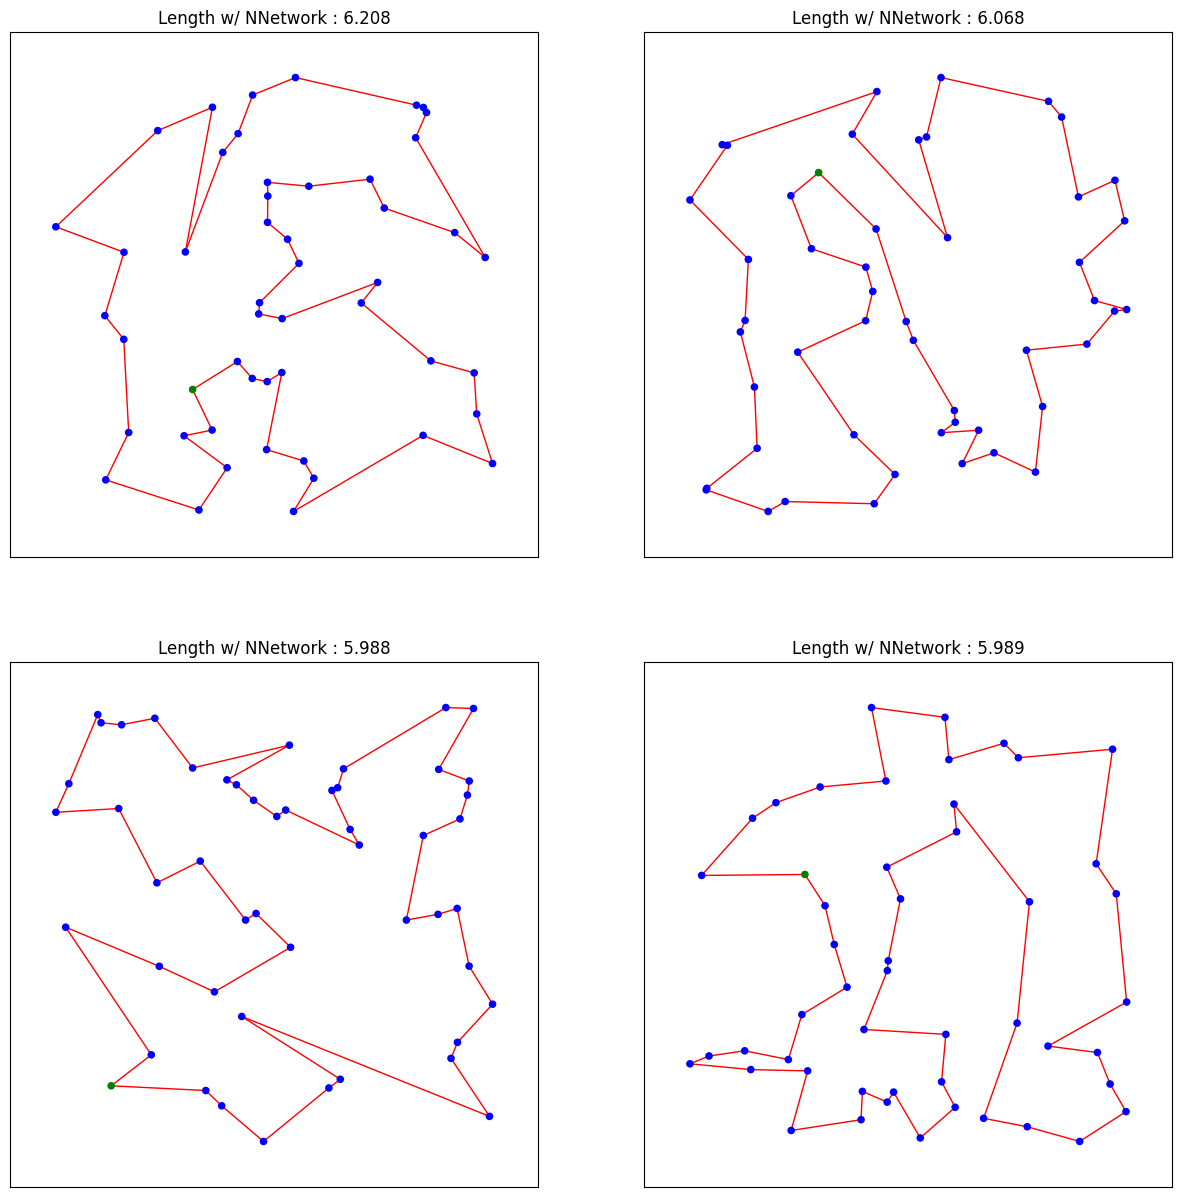

In [2]:
coord_dim = 2
city_count = 50
test_size=2000
device = 'cuda'
torch.random.manual_seed(0)
test_data_loc=f'mamba/data/start_2/test_rand_{test_size}_{city_count}_{coord_dim}.pt'
#test_data = torch.load(test_data_loc).to(device)

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

checkpoint = torch.load('mamba/checkpoints/big/64_G_city50_20-07_17-16.pt')
args = checkpoint['args']
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
model_train.load_state_dict(checkpoint['model_baseline_state_dict'])
x = generate_data(device, 4, city_count, coord_dim)
with torch.no_grad():
    tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True,lastlayer=args.last_layer)
x = x[:,:-1,:]
plot_tsp(x,tour)

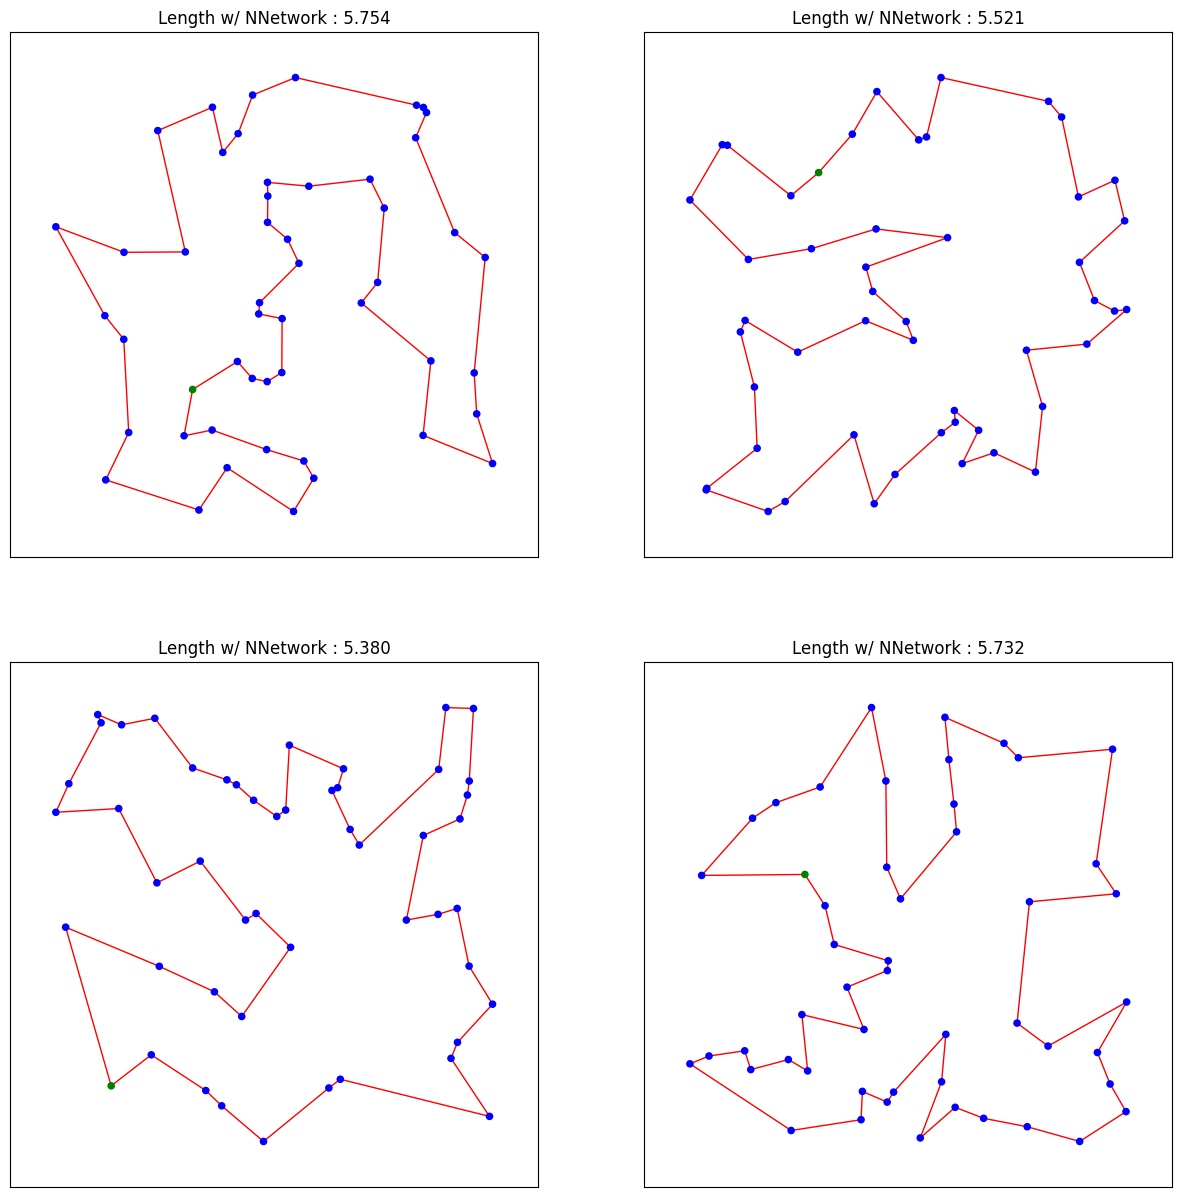

In [6]:
from benchmarks.transformer_model import TSP_net
import torch
nb_nodes = city_count # TSP100
dim_emb = 128
dim_ff = 512
dim_input_nodes = 2
nb_layers_encoder = 6
nb_layers_decoder = 2
nb_heads = 8
max_len_PE = 1000
batchnorm = True

TSP_model = TSP_net(dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,batchnorm).to(device)
TSP_model.eval()
if nb_nodes == 50:
    checkpoint = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl')
elif nb_nodes == 100:
    checkpoint = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_24-06-08--18-43-26-n100-gpu0,1.pkl')
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
TSP_model.load_state_dict(checkpoint['model_baseline'])
with torch.no_grad():
    tours_greedy, _ = TSP_model(x,True)
plot_tsp(x,tours_greedy)

```markdown
# Calculate Benchmarks
```

In [3]:
#Quick overfitting test
import torch
from model import generate_data, seq2seq_generate_tour,MambaFull, compute_tour_length
coord_dim = 2
city_count = 50
test_size=2000
device = 'cuda'
torch.random.manual_seed(0)
test_data_loc=f'mamba/data/start_2/{test_size}_{city_count}_{coord_dim}.pt'
test_data_og = torch.load(test_data_loc).to(device)

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

checkpoint = torch.load('mamba/checkpoints/big/share_50_general_27-07_13-29.pt')
args = checkpoint['args']
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
model_train.load_state_dict(checkpoint['model_baseline_state_dict'])

with torch.no_grad():
    tour, _ = seq2seq_generate_tour(device,model_train,test_data_og,deterministic=True,lastlayer=args.last_layer)
    Loss = compute_tour_length(test_data_og,tour).mean()
    print('Loss:',Loss)
    Loss = 0
    for i in range(10):
        test_data = generate_data(device, 2000, city_count)
        tour, _ = seq2seq_generate_tour(device,model_train,test_data,deterministic=True,lastlayer=args.last_layer)
        Loss += compute_tour_length(test_data,tour).mean()
    print('Average Loss:',Loss/10)

Loss: tensor(6.0348, device='cuda:0')
Average Loss: tensor(6.0407, device='cuda:0')


In [8]:
#Test our best mamba model and greedy solver on 10k test set
import torch
from model import seq2seq_generate_tour,MambaFull, compute_tour_length
#from benchmarks.benchmark_solvers import greedy_tsp

coord_dim = 2
city_count = [50,100]
test_size=10000
device = 'cpu'
torch.random.manual_seed(0)

test_data = [] #(10000,50,2) (10000,100,2)
test_data_with_start = [] #(10000,51,2) (10000,101,2)
test_data_labels = [] #(10000) (10000)

for i in range(2):
    test_data_loc=f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data_tmp = torch.load(test_data_loc).to(device)
    start_data = torch.full((test_size, 1, coord_dim), 2).to(device)
    test_data_tmp2 = torch.cat((test_data_tmp, start_data), dim=1)
    test_data.append(test_data_tmp)
    test_data_with_start.append(test_data_tmp2)

    test_data_label_loc = f'data/transformer_data/10k_TSP{city_count[i]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to(device))

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

#Greedy resutls on transformer test set: 6.99 & 9.6862
'''for i in range(len(city_count)):
    print(test_data[i].shape)
    print(test_data_with_start[i].shape)
    print(greedy_tsp(test_data_with_start[i])[0]) #Greedy'''

checkpoints = [torch.load('mamba/checkpoints/big/share_50_general_27-07_13-29.pt'),
               torch.load('mamba/checkpoints/big/64_G_city100_20-07_22-17.pt')]
transformer_checkpoints = [torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl'),
                           torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl')]

transformer_model = TSP_net(2, 128, 512, 6, 2, 8, 1000,True).to(device)
transformer_model.eval()

Loss_mamba = [] #(10000) (10000)
Loss_transformer = [] #(10000) (10000)
tours_mamba = [] #(10000,50) (10000,100)
tours_transformer = [] #(10000,50) (10000,100)

for i, (checkpoint_m, checkpoint_t) in enumerate(zip(checkpoints, transformer_checkpoints)):
    
    args = checkpoint_m['args']
    model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
    model.load_state_dict(checkpoint_m['model_baseline_state_dict'])
    model.eval()
    if i==0:
        print('CITY 50')
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])
    else:
        print('CITY 100')
        checkpoint_t['model_baseline'] = {k.replace('module.', ''): v for k, v in checkpoint_t['model_baseline'].items()}
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])

    with torch.no_grad():
        tours_mamba.append(seq2seq_generate_tour(device,model,test_data_with_start[i],deterministic=True,lastlayer=args.last_layer)[0])
        Loss_mamba.append(compute_tour_length(test_data_with_start[i],tours_mamba[i]))
        print('Loss:',Loss_mamba[i].mean())

        tours_transformer.append(transformer_model(test_data[i],True)[0])
        Loss_transformer.append(compute_tour_length(test_data[i],tours_transformer[i]))
        print('Loss Transformer:',Loss_transformer[i].mean())

mamba_better = 0
transformer_better=0
for i,j in zip(Loss_mamba,Loss_transformer):
    if i<=j:
        mamba_better+=1
    else:
        transformer_better+=1
print('mamba better  ',mamba_better,', transformer better  ', transformer_better)

torch.Size([10000, 50, 2])
torch.Size([10000, 51, 2])
torch.Size([10000, 100, 2])
torch.Size([10000, 101, 2])
torch.Size([10000, 50, 2])
torch.Size([10000, 51, 2])
50


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [13:36<00:00, 16.33s/it]


tensor(6.9899)
torch.Size([10000, 100, 2])
torch.Size([10000, 101, 2])
100


100%|██████████| 100/100 [43:28<00:00, 26.08s/it]

tensor(9.6862)


"checkpoint = torch.load('mamba/checkpoints/big/share_50_general_27-07_13-29.pt')\nargs = checkpoint['args']\nmodel_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)\nmodel_train.load_state_dict(checkpoint['model_baseline_state_dict'])\n\nwith torch.no_grad():\n    tour, _ = seq2seq_generate_tour(device,model_train,test_data_og,deterministic=True,lastlayer=args.last_layer)\n    Loss = compute_tour_length(test_data_og,tour).mean()\n    print('Loss:',Loss)\n    Loss = 0\n    for i in range(10):\n        test_data = generate_data(device, 2000, city_count)\n        tour, _ = seq2seq_generate_tour(device,model_train,test_data,deterministic=True,lastlayer=args.last_layer)\n        Loss += compute_tour_length(test_data,tour).mean()\n    print('Average Loss:',Loss/10)"

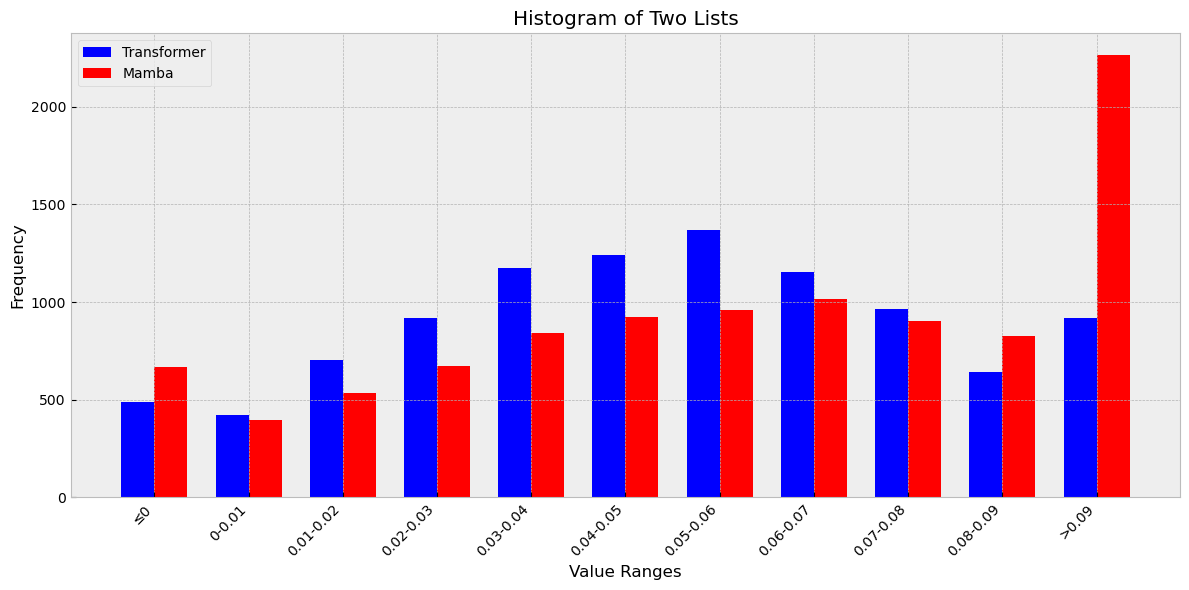

In [11]:
#Histogram
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('bmh')
# Generate sample data (replace this with your actual data)
list1 = np.random.normal(0.05, 0.03, 10000)
list2 = np.random.normal(0.06, 0.04, 10000)

# Define bin edges
bin_edges = [-np.inf, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, np.inf]

# Create histogram data
hist1, _ = np.histogram(list1, bins=bin_edges)
hist2, _ = np.histogram(list2, bins=bin_edges)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the positions of the bars on the x-axis
r1 = np.arange(len(hist1))
r2 = [x + 0.35 for x in r1]

# Create the grouped bar chart
ax.bar(r1, hist1, color='blue', width=0.35, label='Transformer', align='center')
ax.bar(r2, hist2, color='red', width=0.35, label='Mamba', align='center')

# Customize the plot
ax.set_xlabel('Value Ranges')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Two Lists')
ax.set_xticks([r + 0.175 for r in range(len(hist1))])
ax.set_xticklabels(['≤0', '0-0.01', '0.01-0.02', '0.02-0.03', '0.03-0.04', '0.04-0.05', 
                    '0.05-0.06', '0.06-0.07', '0.07-0.08', '0.08-0.09', '>0.09'])
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Concorde

Problem Name: 5c12685fe9534ee8bf4c3bebebc58942
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1856
   0 Steps   Best: 1579   0.00 seconds
  10 Steps   Best: 1576   0.02 seconds
  50 Total Steps.
Best cycle length: 1576
Lin-Kernighan Running Time: 0.04
LK Initial Run: 1576.0
LK Run 0: 1572.0
LK Run from best tour: 1572.0
Time to find compression tour: 0.13 (seconds)
Set initial upperbound to 1572 (from tour)
Fractional Matching: 1535.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1572.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  154 columns  308 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1535.000000
Setting tolerances: next cuts 0.3700 next round 0.0370
CCtsp_init_

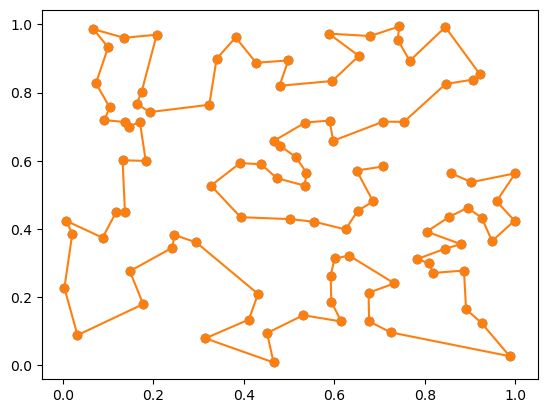

1572.0


In [2]:
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from benchmarks.pyconcorde.concorde.tests.data_utils import get_dataset_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
x_coord_i = np.random.rand(100,2)
plt.plot(x_coord_i[:,0],x_coord_i[:,1],'o')
graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]

# Solve the TSP problem
solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
solution = solver.solve()

# Plot the tour
plt.plot(x_coord_i[solution.tour, 0], x_coord_i[solution.tour, 1], 'o-')

# Display the plot
plt.show()
print(solution.optimal_value)

Transformer

In [1]:
from benchmarks.transformer_model import TSP_net
import torch
from model import compute_tour_length
device = 'cuda'
dim_emb = 128
dim_ff = 512
dim_input_nodes = 2
nb_layers_encoder = 6
nb_layers_decoder = 2
nb_heads = 8
max_len_PE = 1000
batchnorm = True

TSP_model = TSP_net(dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,batchnorm).to(device)

print('Total number of parameters:', sum(p.numel() for p in TSP_model.parameters()))

TSP_model.eval()
checkpoint_50 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl')
#checkpoint_100 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_24-06-08--18-43-26-n100-gpu0,1.pkl')
checkpoint_100 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl')

test_input_50 = torch.load('mamba/data/start_2/2000_50_2.pt').to(device)
test_input_100 = torch.load('mamba/data/start_2/2000_100_2.pt').to(device)
test_input_50 = test_input_50[:,:-1,:]
test_input_100 = test_input_100[:,:-1,:]
print(test_input_50.shape)
print(test_input_100.shape)

with torch.no_grad():
    TSP_model.load_state_dict(checkpoint_50['model_baseline'])
    tours_greedy_50, _ = TSP_model(test_input_50,True)
    checkpoint_100['model_baseline'] = {k.replace('module.', ''): v for k, v in checkpoint_100['model_baseline'].items()}
    TSP_model.load_state_dict(checkpoint_100['model_baseline'])
    tours_greedy_100, _ = TSP_model(test_input_100,True)
    
print(compute_tour_length(test_input_50,tours_greedy_50,remove_start_token=False).mean()) #5.7031
print(compute_tour_length(test_input_100,tours_greedy_100,remove_start_token=False).mean()) #7.8718


Total number of parameters: 1405568
torch.Size([2000, 50, 2])
torch.Size([2000, 100, 2])
tensor(5.7031, device='cuda:0')
tensor(7.8718, device='cuda:0')


Greedy

In [6]:
from benchmarks.benchmark_solvers import greedy_tsp

NameError: name 'Greedy' is not defined